<a href="https://colab.research.google.com/github/ishankaul1/cs5262/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Background**

Following the recent pandemic, the tumultuous world economy, and major wars throughout the globe, mental health is more than ever a huge topic of discussion in modern society. CDC data shows that between 2019 and 2021, rates of mental health care have increased by 5% among adults in the US. In addition,tech companies such as Calm (valued over $2 billion) have cashed out on the new emphasis on mental health. As an individual who highly values my own mental health and takes great care to optimize and regulate my daily mood, I wanted to explore what features of someone's lifestyle.


**Description**

This project will explore a lifestyle and wellbeing [dataset](https://www.kaggle.com/datasets/ydalat/lifestyle-and-wellbeing-data) I found on Kaggle, to determine what factors about someone's lifestyle might affect their mental well-being. Although the definition of what a 'good' or 'bad' state of mental health might be is subjective, I plan on using a combination of the two dataset columns 'Daily Stress', and 'Daily Shouting' as my indicator of how good or bad an individual's mental health is.


**Performance Metric**

I will be formulating the Mental Health score as a binary classifier, with the value dependent upon both 'Daily Stress' and 'Daily Shouting'. Based on my initial analysis of the data for both columns, I will consider a '1' in the Mental Health score to be 

```
Daily_Shouting > 1 OR Daily_Stress > 2
```
This is subject to change, and I may end up using a more elaborate formula to determine the binary value as I research more ways to combine data.
The main performance metric I'll be using is F1 score on predicting the Mental Health score, as it seems to be a widely accepted assessment of model results. However, I will definitely take a look at precision, recall, accuracy, and other performance metrics we learn in class for further analysis on my models. 


In [2]:
#import necessary libraries and read data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

wellbeing_data = pd.read_csv('Wellbeing_and_lifestyle_data_Kaggle.csv')
display(wellbeing_data.sample(1))

,Timestamp,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,...,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
870,9/22/15,2,2,4,10,4,4,3,5,2,...,8,0,5,2,3,2,10,51 or more,Female,654.3


**Exploratory Data Analysis**

Before feeding the data to machine learning models, I will explore various properties of the dataset to determing what transformations might be made to maximize its effectiveness on desirable predictions. The questions I plan to answer are:

1. Do any columns have significant amounts of missing data? Depending on the severity of missing data and what features are missing, a decision must be made to either impute the data somehow, or toss the incomplete rows.

In [3]:
wellbeing_data.info() #only had to run this one line to answer question 1, since there's no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

In [4]:
#Initial preprocessing needed for EDA.

#Droping this value because it's calculated by the agency that collected this data based on the other features.
wellbeing_data = wellbeing_data.drop(['WORK_LIFE_BALANCE_SCORE'], axis=1)

#DAILY_STRESS is really an int value, but there was one garbage value that was causing me trouble
#in the next line. Since it was only one, I dropped it rather than imputing
wellbeing_data = wellbeing_data[wellbeing_data['DAILY_STRESS'].apply(lambda x: str(x).isdigit())]
#converting daily_stress to int to work out of the box with pandas histograms
wellbeing_data['DAILY_STRESS'] = wellbeing_data['DAILY_STRESS'].astype(str).astype(int)

wellbeing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15971 entries, 0 to 15971
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Timestamp          15971 non-null  object
 1   FRUITS_VEGGIES     15971 non-null  int64 
 2   DAILY_STRESS       15971 non-null  int64 
 3   PLACES_VISITED     15971 non-null  int64 
 4   CORE_CIRCLE        15971 non-null  int64 
 5   SUPPORTING_OTHERS  15971 non-null  int64 
 6   SOCIAL_NETWORK     15971 non-null  int64 
 7   ACHIEVEMENT        15971 non-null  int64 
 8   DONATION           15971 non-null  int64 
 9   BMI_RANGE          15971 non-null  int64 
 10  TODO_COMPLETED     15971 non-null  int64 
 11  FLOW               15971 non-null  int64 
 12  DAILY_STEPS        15971 non-null  int64 
 13  LIVE_VISION        15971 non-null  int64 
 14  SLEEP_HOURS        15971 non-null  int64 
 15  LOST_VACATION      15971 non-null  int64 
 16  DAILY_SHOUTING     15971 non-null  int64

2. How are the values for each feature distributed? Our features may be heavily skewed one way or another, especially since many of them are numerical answers where '10' simply represents 10 or more. It's very possible that a heavy skew will result in some loss of prediction power, and it may be more effective to transform skewed columns into larger categorical ranges (for example, 10 or more versus less than 10).

FRUITS_VEGGIES
DAILY_STRESS
PLACES_VISITED
CORE_CIRCLE
SUPPORTING_OTHERS
SOCIAL_NETWORK
ACHIEVEMENT
DONATION
BMI_RANGE
TODO_COMPLETED
FLOW
DAILY_STEPS
LIVE_VISION
SLEEP_HOURS
LOST_VACATION
DAILY_SHOUTING
SUFFICIENT_INCOME
PERSONAL_AWARDS
TIME_FOR_PASSION
WEEKLY_MEDITATION


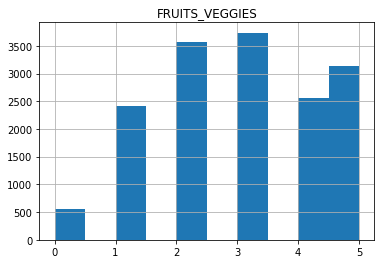

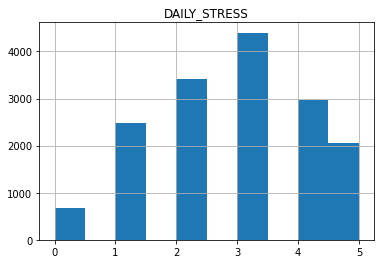

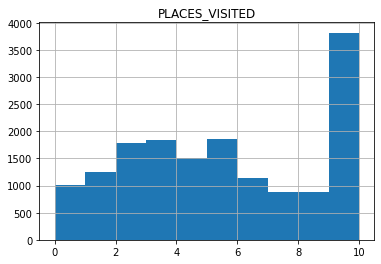

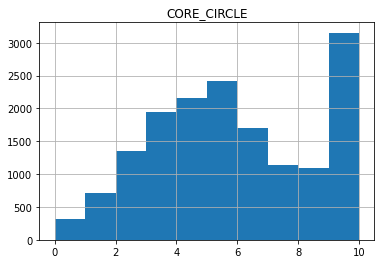

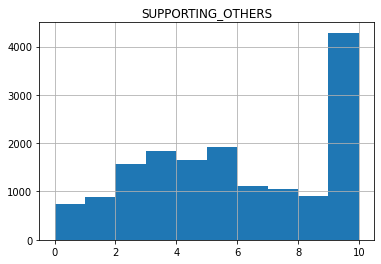

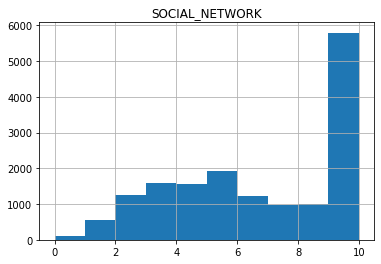

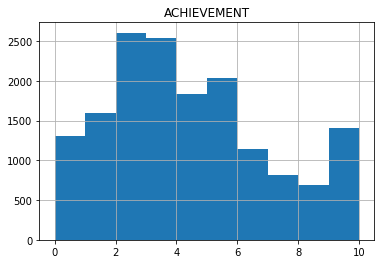

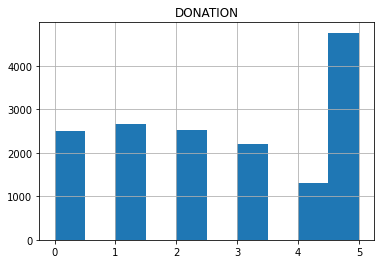

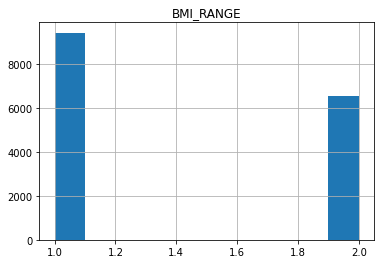

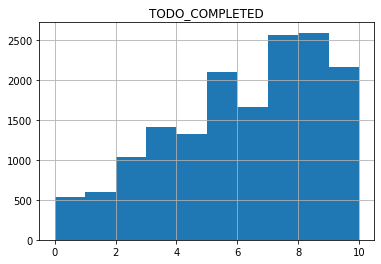

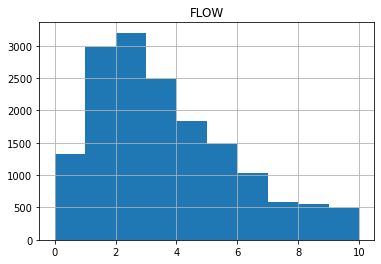

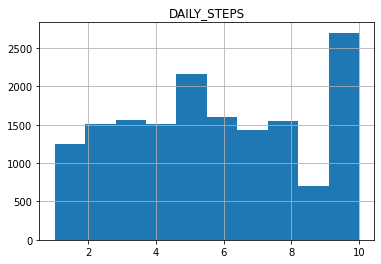

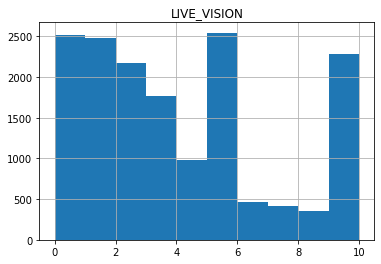

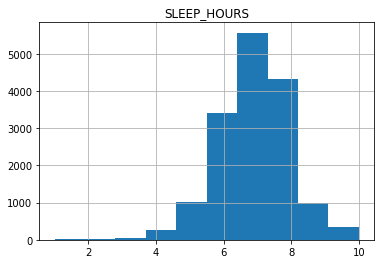

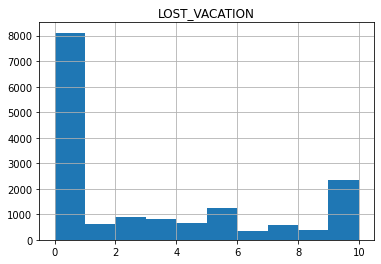

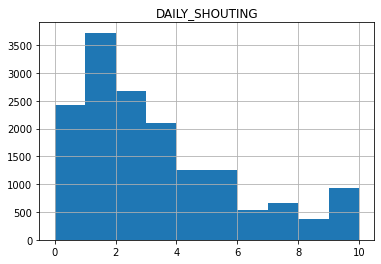

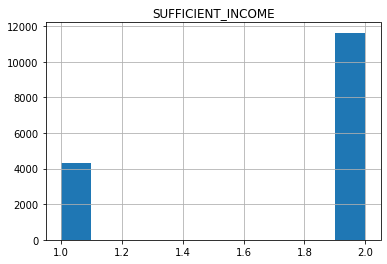

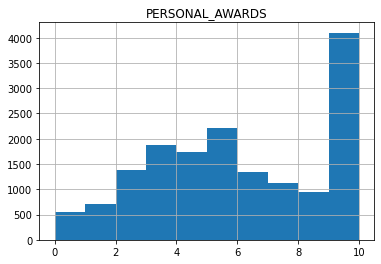

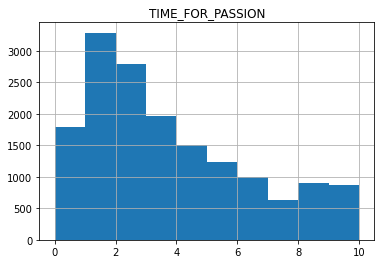

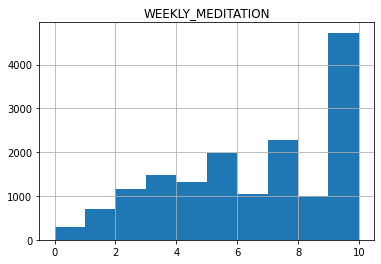

In [5]:
#Raw timestamp wouldn't make sense in a histogram
SKIP_HIST_COLUMNS = {'Timestamp'}
#Age and gender are 'string' columns, so I have to plot their 'value_counts' instead of the raw columns.
STRING_COLUMNS = {'AGE', 'GENDER'}
#plot histograms of each feature for easy visualization
integer_column_names = list(filter(lambda x : x not in SKIP_HIST_COLUMNS and x not in STRING_COLUMNS, list(wellbeing_data.columns.values)))

for col in integer_column_names:
  print(col)
  wellbeing_data.hist(column=col)



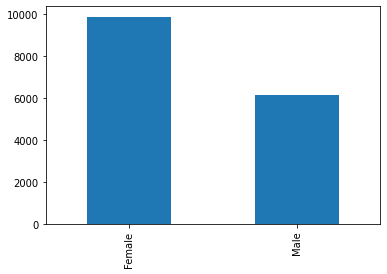

In [ ]:
display(wellbeing_data['GENDER'].value_counts().plot(kind='bar'))

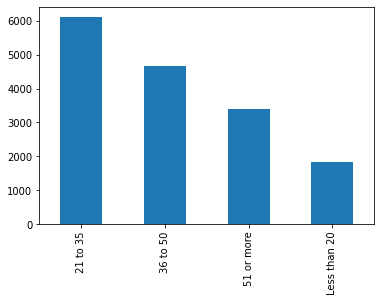

In [ ]:
display(wellbeing_data['AGE'].value_counts().plot(kind='bar'))

3. What are the correlations of values between each variable? Some variables may be heavily correlated with one another, and therefore overly complicate the algorithm without providing any more useful knowledge. Since most of my variables are numeric, a correlation matrix makes sense, although their values being capped at 5 or 10 may throw off the numbers. 


In [6]:
cormat = wellbeing_data.corr()
display(cormat)

,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION
FRUITS_VEGGIES,1.000000,-0.094535,0.254906,0.157785,0.204469,0.106941,0.162901,0.199462,-0.092976,0.227005,0.133083,0.251213,0.110106,0.103633,-0.074115,-0.072914,0.148239,0.167823,0.164581,0.196104
DAILY_STRESS,-0.094535,1.000000,-0.134857,-0.120238,-0.029852,0.020930,-0.110943,-0.037721,0.083110,-0.163727,-0.129903,-0.065511,-0.134155,-0.157037,0.196953,0.302669,-0.144573,-0.042535,-0.158141,-0.218660
PLACES_VISITED,0.254906,-0.134857,1.000000,0.255803,0.237981,0.149358,0.257960,0.204597,-0.108054,0.227671,0.138747,0.196128,0.143688,0.127251,-0.129167,-0.092114,0.176672,0.269723,0.177892,0.209254
CORE_CIRCLE,0.157785,-0.120238,0.255803,1.000000,0.337859,0.308773,0.289460,0.221875,-0.025965,0.224380,0.238085,0.148021,0.219929,0.066325,-0.080804,-0.066590,0.123117,0.253981,0.227796,0.105240
SUPPORTING_OTHERS,0.204469,-0.029852,0.237981,0.337859,1.000000,0.316200,0.360077,0.393149,0.038558,0.256698,0.278479,0.147592,0.236726,0.007125,-0.018256,-0.048295,0.113340,0.332666,0.327750,0.144307
SOCIAL_NETWORK,0.106941,0.020930,0.149358,0.308773,0.316200,1.000000,0.249025,0.156792,0.019843,0.204438,0.244620,0.215799,0.182507,-0.029662,0.016506,-0.000050,0.123638,0.209041,0.200535,-0.006609
ACHIEVEMENT,0.162901,-0.110943,0.257960,0.289460,0.360077,0.249025,1.000000,0.233697,-0.019699,0.304972,0.386577,0.185946,0.320680,0.045261,0.000727,-0.044488,0.113779,0.396180,0.368936,0.164713
DONATION,0.199462,-0.037721,0.204597,0.221875,0.393149,0.156792,0.233697,1.000000,0.064543,0.193845,0.172498,0.113415,0.164857,-0.001343,-0.022287,-0.046904,0.120585,0.277735,0.193055,0.144197
BMI_RANGE,-0.092976,0.083110,-0.108054,-0.025965,0.038558,0.019843,-0.019699,0.064543,1.000000,-0.061508,0.026761,-0.131465,0.000088,-0.098156,0.036683,0.060470,-0.011863,0.019007,-0.006237,-0.078189
TODO_COMPLETED,0.227005,-0.163727,0.227671,0.224380,0.256698,0.204438,0.304972,0.193845,-0.061508,1.000000,0.301297,0.200432,0.269876,0.113617,-0.078484,-0.135582,0.203841,0.247069,0.274486,0.182571


4. The 'Timestamp' column tells us when the survey was collected. I want to know when the start/end dates of data collection were, as mental well-being could easily be influenced by when data was collected, especially in recent years. For example, I'd assume people were generally more depressed during the peak of Covid lockdowns, and when recessions were occuring.

In [8]:
wellbeing_data['Timestamp'] = pd.to_datetime(wellbeing_data['Timestamp'])
wellbeing_data['Timestamp'].agg(['min', 'max'])

min   2015-07-07 00:00:00
max   2021-03-14 09:03:00
Name: Timestamp, dtype: datetime64[ns]

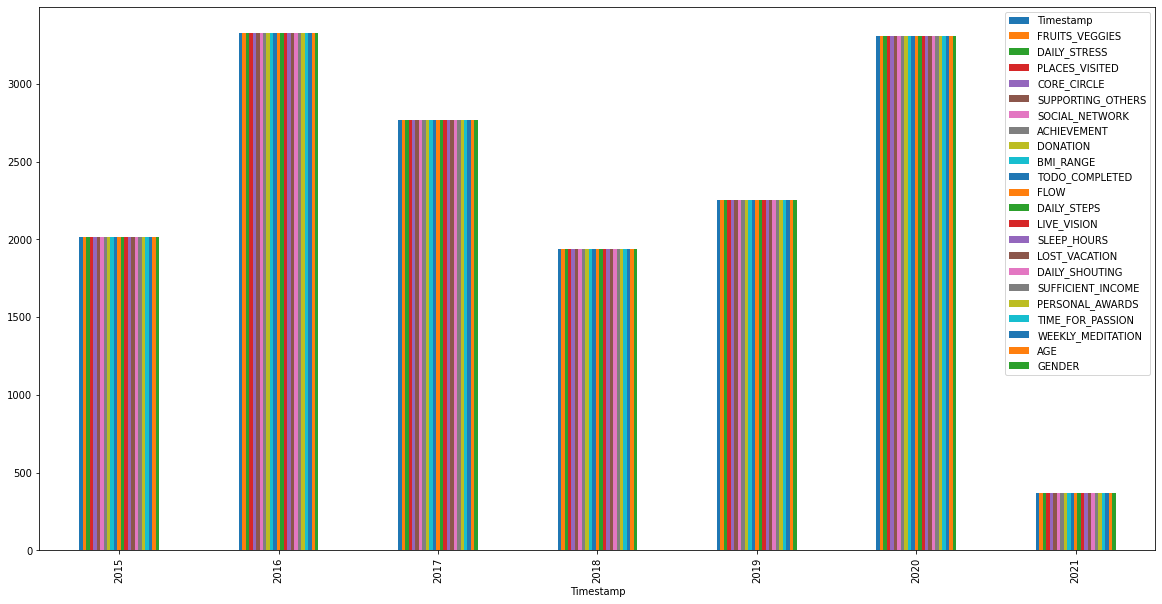

In [ ]:
wellbeing_data.groupby([wellbeing_data['Timestamp'].dt.year]).count().plot(kind="bar", figsize=(20, 10))

**Exploratory Data Analysis Findings**

1. No columns had significant amounts of missing data. I only had to drop one row for a singular bad value.

2. Only three of the numeric features (Daily_Stress, Fruits_Veggies, and Sleep_hours) had relatively un-skewed bell curves. Flow, Achievement, Daily Shouting, and Time for Passion all skewed left. Places Visited, Core Circle, Supporting Others, Social Network, Donation, Personal Awards, and Weekly Meditation all skewed slightly left, but had a much higher value for '10 or more' than the rest of the values. 
Lost Vacation had a drastic difference between the counts of 0 values and any other, and Meditation had had a similarly drastic difference between 10 or more and the rest.
More Females and younger people completed the survey, as well as people with BMIs < 25, although not by drastic amounts.
Most of the people completing the survey had sufficient income to cover their expenses.

3. Most of the features did not seem to be highly correlated. Flow, Achievement, and Time for Passion seemed to be the most highly correlated group of features, with Flow and Time for Passion having the highest correlation of 0.48. 

4. All data was collected between July 2015 and March 2021. A significant proportion of data was collected during the years of Covid lockdowns (2020 and 2021).

These results will be discussed more deeply and mapped to feature engineering tasks in the next section.

**Feature Engineering - Initial Plan**

For the most part, I will leave the numeric features as is. Most of the have some skew, but making them categorical would lose valuable information that might affect the model. 
Since Lost Vacation and Meditation had such high values for 0 and 10, it's worth experimenting with turning each into a binary value. Lost Vacation's values would be 0='none', 1='some', and Mediation would be 0='less than 10', 1='greater than or equal to 10'.
I don't think any of the variables were correlated enough to consider dropping. However, just for experiment's sake, I will experiment with dropping Flow and Time for Passion in separate models.
Since a substantial portion of the data was collected during Covid lockdowns, I plan on transforming the timestamps into one binary column called 'During Lockdown', based on my hypothesis that the lockdowns might have significantly affected mental health. In addition, I will create another categorical column called 'Season', representing what season the data was collected during. My reasoning for this is my strong belief that seasonal depression is a thing.

**Train Test Split**

Since this dataset is pretty large (>15000 usable rows), I will be using a Train, Test, Holdout split.
The percentages will be 70/15/15 Train/Test/Holdout.

**Initial Pipeline**

I will not need any imputation transformers to work with this dataset. However, several column transformers will need to be experimented with, leading to several different 'branches' of my pipeline.
For Lost Vacation, a transformer will be applied to transform it into a binary categorical feature, with values = 0 being 0, and values >0 being 1.
A transformer for Meditation will transform it into a binary categorical value, with values less than 10 mapping to 0, and greater than 10 mapping to 1.
Yet another transformer will be applied to Timestamp, to turn it into the categorical 'Season' and 'During_Lockdown' columns discussed in the previous section. We will also experiment with transformers that drop either of Time for Passion and Flow. Finally, I will try Scaler transforms on all numerical columns to see if it makes a difference, although given that most are on a scale of 0-10 or 0-5 already, I hypothesize that it won't make much of a difference.

**Model Fitting and Evaluation**

Some assumptions I have about feature importance are:
1. BMI range won't be a very important feature, as many athletic and healthy people have a BMI over 25. Likewise, many people with dwindling health may have a BMI under 25.
2. Flow, Sufficient Income, and Core Circle will be the features that have the most drastic affect on model accuracy.
3. A much higher proportion of people will have reported worse mental health during lockdowns. However, not being in a lockdown will be pretty well distributed either way. 

**Further EDA (Assignment 4)**
1. Transform Timestamp data in to During_Lockdown and Seasons; then run histograms on each transformed category

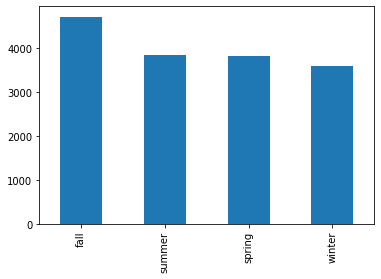

In [15]:
# Note - just implementing the transforms as lambdas for the feature engineering exercise; will convert to a transformer class during pipeline stage
def timestamp_to_season(l):
  seasons_list_by_month_index = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter' ]
  return list(map(lambda x : seasons_list_by_month_index[x.month-1], l ))

#There were a lot of choices for what to consider the 'start' and 'end' to the pandemic. For the purposes of this project,
#I chose the start of shutdowns in the United States (March 15, 2020), and the date of removal of the last indoor universal mask 
#mandate in the US (Hawaii, March 26, 2022)
#Source: https://www.cdc.gov/museum/timeline/covid19.html

seasons_col = timestamp_to_season(wellbeing_data['Timestamp'])
seasons_df = pd.DataFrame()
seasons_df['seasons'] = seasons_col

display(seasons_df['seasons'].value_counts().plot(kind='bar'))





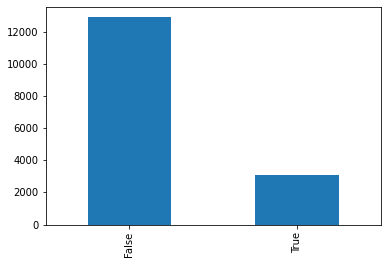

In [16]:

import datetime

def timestamp_to_during_covid_restrictions(l):
  date_start = datetime.datetime(2020, 3, 15)
  date_end = datetime.datetime(2022, 3, 28)
  return list(map(lambda x : x > date_start and x < date_end, l))

covid_restrictions_col = timestamp_to_during_covid_restrictions(wellbeing_data['Timestamp'])
covid_restrictions_df = pd.DataFrame()
covid_restrictions_df['during_restrictions'] = covid_restrictions_col

display(covid_restrictions_df['during_restrictions'].value_counts().plot(kind='bar'))


  2. Transform DAILY_SHOUT and DAILY_STRESS into the combined column; determine how imbalanced the classes are

False    15114
True       857
Name: scores, dtype: int64

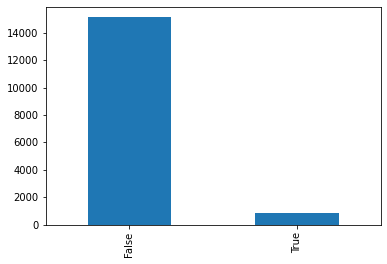

In [28]:
def daily_shout_and_stress_to_is_mentally_healthy(shout_list, stress_list):
  result = []
  for (shout, stress) in zip(shout_list, stress_list):
    result.append(shout < 1 and stress < 2)
  return result

shout = wellbeing_data['DAILY_SHOUTING']
stress = wellbeing_data['DAILY_STRESS']

health_scores = daily_shout_and_stress_to_is_mentally_healthy(shout, stress)
health_scores_df = pd.DataFrame()
health_scores_df['scores'] = health_scores

display(health_scores_df['scores'].value_counts())
display(health_scores_df['scores'].value_counts().plot(kind='bar'))


Considering this class was pretty imbalanced, I figure it might not be fair to say that only 5% of the population is mentally healthy (although that might be true by my own personal standards). Therefore, I decided to do some further exploration, and try to find some more relaxed thresholds that allowed me to use both columns and still have a relatively balanced class. The numbers I found were DAILY_SHOUT < 3 and DAILY_STRESS < 4.

False    9221
True     6750
Name: scores, dtype: int64

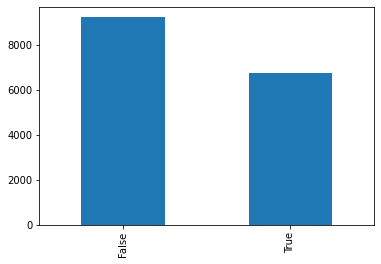

In [29]:
def daily_shout_and_stress_to_is_mentally_healthy_revised(shout_list, stress_list):
  result = []
  for (shout, stress) in zip(shout_list, stress_list):
    result.append(shout < 3 and stress < 4)
  return result

shout = wellbeing_data['DAILY_SHOUTING']
stress = wellbeing_data['DAILY_STRESS']

health_scores = daily_shout_and_stress_to_is_mentally_healthy_revised(shout, stress)
health_scores_df = pd.DataFrame()
health_scores_df['scores'] = health_scores

display(health_scores_df['scores'].value_counts())
display(health_scores_df['scores'].value_counts().plot(kind='bar'))

**Further EDA Results**

**Feature Engineering**

**Pipeline Plan**